In [1]:
import matplotlib.pylab as plt
from mpl_toolkits.axes_grid1.axes_rgb import RGBAxes
import numpy as np
import xarray as xr
from os.path import join
import reader
import pandas as pd
from numpy.linalg import det

## Read the data

In [2]:
fname = "/data/jol/sat_data/sar_polar/cvms/CovMat.mat"
ds = reader.read_covar_matrix(fname)
# Write to MATLAB files
# for cm in ds.keys():
#    sio.savemat(f'data/CovMat_{cm}.mat', {'CovMat': ds[k].values})

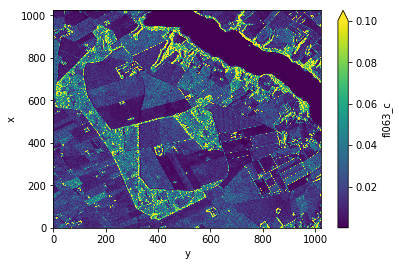

In [51]:
np.flip(np.abs(ds['fl063_c'].isel(i=1, j=1)), axis=0).plot(vmax=.1);

## Plot the field mask

The mask labels are as follows:

1	Rye <br>
2	Grass (Rajgræs)<br>
3	Winter wheat<br>
4	Grass (Rajgræs)<br>
5	Winter wheat<br>
6	Spring barley<br>
7	Peas<br>
8	Rye<br>
9	Spring oats<br>
10	Grass (Rajgræs)<br>
11	Winter wheat<br>
12	Rye<br>
13	Spring barley<br>
14	Spring barley<br>
15	Peas<br>
16	Grass (Rajgræs)<br>
17	Winter barley<br>
18	Peas<br>
19	Peas<br>
20	Winter wheat<br>
21	Peas<br>
22	Winter wheat<br>
23	Rye<br>
24	Peas<br>
25	Winter barley<br>
26	Grass (Rajgræs)<br>
27	Winter wheat<br>
28	Peas<br>
29	Spring barley<br>
30	Beets<br>
31	Spring barley<br>
32	Grass (slet græs)<br>
33	Winter wheat<br>
34	Spring barley<br>
35	Winter wheat<br>
36	Spring barley<br>
37	Peas<br>

101 Lake<br>

/home/jol/anaconda3/envs/raster/lib/python3.7/site-packages/rasterio/__init__.py:193: UserWarning: Dataset has no geotransform set.  Default transform will be applied (Affine.identity())
  s.start()


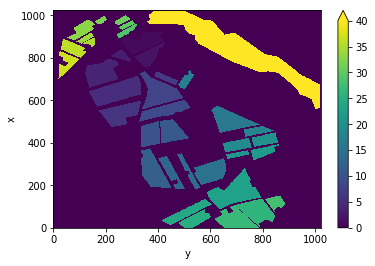

In [5]:
mask = xr.open_rasterio('data/foulum_field_mask.tif').squeeze()
mask = xr.DataArray(mask.values, dims=('x', 'y'))
#import scipy.io as sio
#sio.savemat('data/foulum_field_mask.mat', {'fields': mask.values})
np.flip(mask, axis=0).plot(vmax=40);

## Make RGB plots

fl063_c


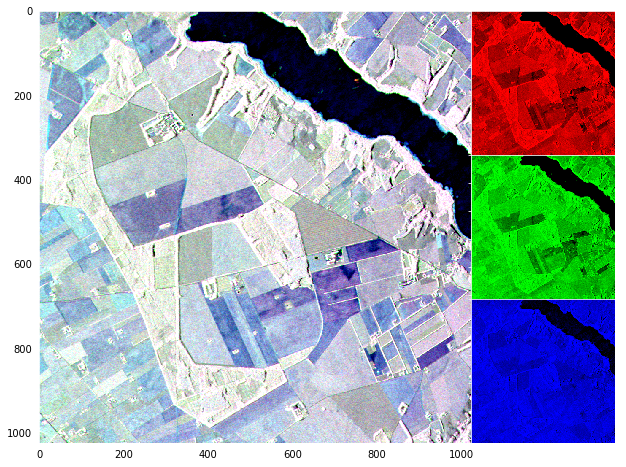

fl063_l


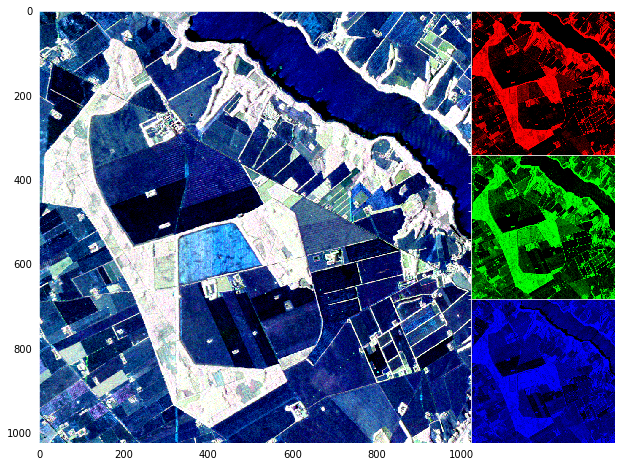

fl064_c


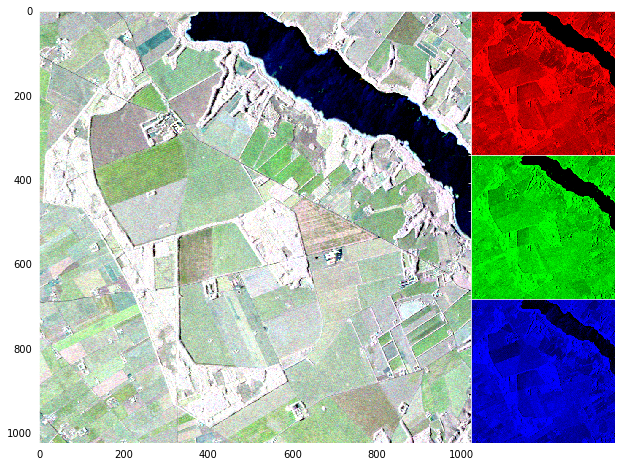

fl064_l


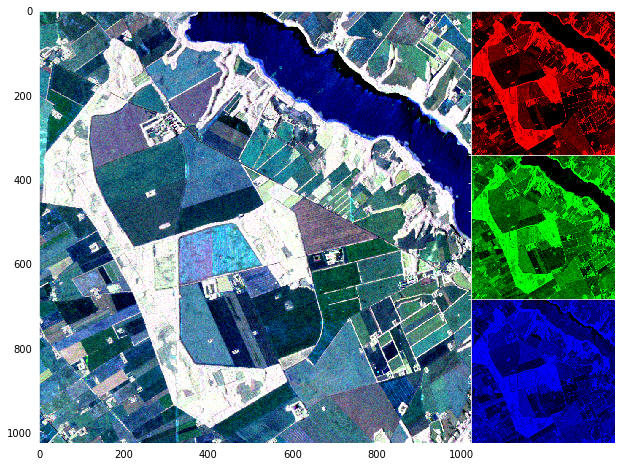

fl065_c


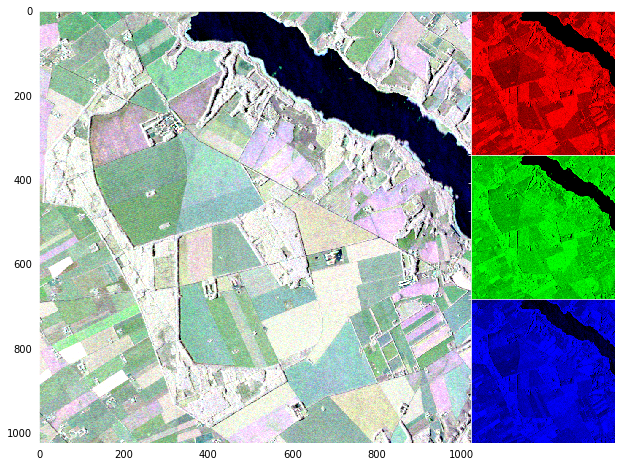

fl065_l


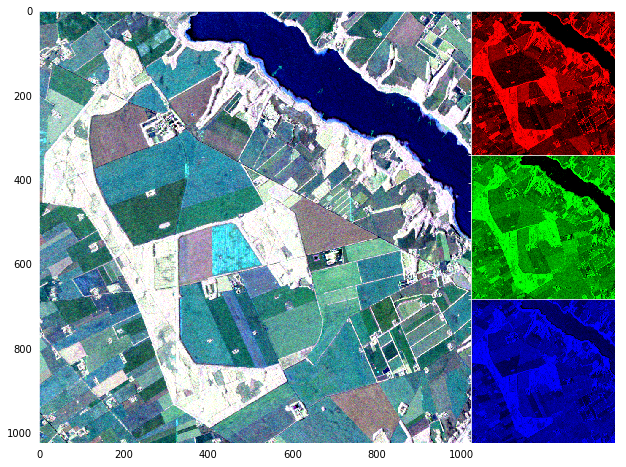

fl068_c


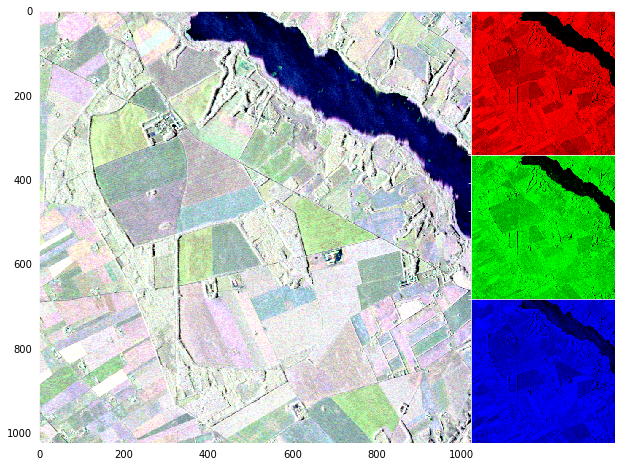

In [6]:
def normalise(c, q=0.90):
    c = c.real
    c = np.clip(c / np.quantile(c, q), 0.01, 1)
    c = (2 + np.log10(c))/2 
    return c 

for v in list(ds.variables):
    da = ds[v]
    rgb = [da.isel(i=i,j=j) for i, j in [(1 ,1), (0, 0), (2, 2)]]
    #rgb_means = np.array([float((np.abs(c)**1).mean()) for c in rgb])
    #rgb_means = rgb_means/rgb_means.max()
    #rgb_means[2] /= 2
    #rgb = [normalise(c)*rgb_means[i] for i, c in enumerate(rgb)]
    rgb = [normalise(c) for i, c in enumerate(rgb)]
    
    fig = plt.figure(figsize=(10, 10))
    #fig.text(0.5,0,v)
    ax = RGBAxes(fig, [0.1, 0.1, 0.8, 0.8])
    print(v)
    ax.imshow_rgb(*rgb)
    plt.show()
    #fname = join('/data/jol/sat_data/sar_polar/plots', v + '.png')
    #fig.savefig(fname, tightlayout=True)

## Caculate the ENLs

$\text{ENL} = \frac{E^2}{\sigma^2}$


In [7]:
diag_els = [(0, 0), (2, 2)]
all_els =[(i, j) for i in range(3) for j in range(3)]
def ENLs(field, k):
    for i, j in diag_els:
        ss = np.abs(ds[k].where(mask==field).sel(i=i, j=j))
        #np.abs(np.flip(ss, axis=0)).plot(vmax=10)
        #plt.title(f"m = {i}, p = {j}")
        #plt.show()
        #amp = 10**(10*np.abs(ss))
        E = ss.mean()
        Var = np.abs(ss).std(skipna=True)**2
        yield k, field, f"{i}{j}", float(E**2/Var)

def get_enls():
    for cov_matrix in ds.variables.keys():
        for field in range(1, 38):
            yield from ENLs(field, cov_matrix)

In [8]:
import warnings
warnings.simplefilter("ignore") 
enl_df = pd.DataFrame(list(get_enls()), columns=['cvm', 'field', 'ij', 'enls'])
enl_df = enl_df.sort_values(by=['cvm', 'field'])

Histograms of the ENLs for each covariance matrix.

The C band has values up to about 14 and the L up to about 10.

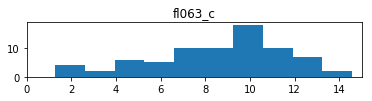

            enls                   max
ij            00         22           
field                                 
32     14.574822  12.119278  14.574822
7      13.812846  12.793229  13.812846
17     13.118739  10.578544  13.118739
26     13.105780  11.428060  13.105780
10     12.744379  12.435655  12.744379
11     12.376579  11.534913  12.376579
8      11.736764  11.852896  11.852896
28      7.853456  11.573539  11.573539
4      11.175772  11.332746  11.332746
16     11.261552   9.813887  11.261552


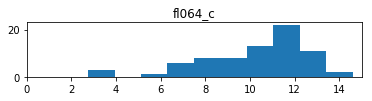

            enls                   max
ij            00         22           
field                                 
29     14.591362  12.287135  14.591362
6      13.657099  12.656351  13.657099
18     13.336574  11.421870  13.336574
21     13.266271  11.622056  13.266271
24     12.915799  11.543450  12.915799
9      12.776931  11.850168  12.776931
20     12.633344  10.376833  12.633344
28     12.544323  12.131470  12.544323
32     12.477813   9.772243  12.477813
7      11.876214  12.401570  12.401570


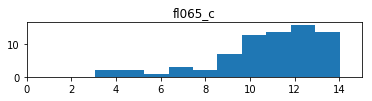

            enls                   max
ij            00         22           
field                                 
15     14.012592  12.808177  14.012592
21     13.676818  12.699479  13.676818
13     13.617224  10.149311  13.617224
24     13.615926  12.777492  13.615926
37     13.550413  11.994182  13.550413
25     13.307631   5.695460  13.307631
9      13.276539  11.282073  13.276539
6      13.273366  11.541771  13.273366
7      13.237267   7.445939  13.237267
18     13.216731  12.755647  13.216731


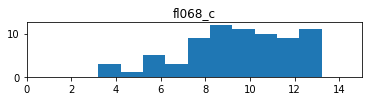

            enls                   max
ij            00         22           
field                                 
28     13.213914  11.898642  13.213914
7      13.197660  10.992015  13.197660
15     13.087620  12.262782  13.087620
14     13.079086  11.685410  13.079086
34     12.933201  10.727060  12.933201
37     12.513279  12.096480  12.513279
19     12.446493   8.743364  12.446493
13     12.433331   8.473361  12.433331
36     12.336399   8.793622  12.336399
9      12.294793   7.563814  12.294793


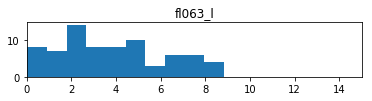

           enls                 max
ij           00        22          
field                              
14     8.841093  5.757326  8.841093
28     8.502121  7.546107  8.502121
30     8.456718  8.309621  8.456718
7      5.647993  7.823119  7.823119
13     7.722982  4.981649  7.722982
25     6.565259  7.440813  7.440813
20     2.293420  7.185657  7.185657
2      3.240384  7.094592  7.094592
9      6.825471  6.309656  6.825471
26     3.569053  6.605364  6.605364


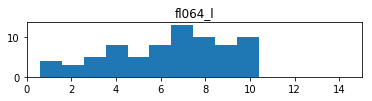

            enls                   max
ij            00         22           
field                                 
9       9.423795  10.381841  10.381841
6      10.165342  10.256452  10.256452
4       8.116849  10.017444  10.017444
32      9.886992   9.570220   9.886992
3       8.620812   9.721315   9.721315
26      9.584750   6.996339   9.584750
5       7.887511   9.501601   9.501601
24      9.210412   6.015487   9.210412
20      9.129390   6.648374   9.129390
18      8.928425   4.660786   8.928425


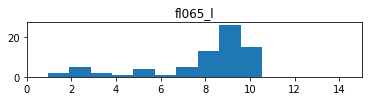

            enls                   max
ij            00         22           
field                                 
3      10.370380  10.536990  10.536990
15      9.718028  10.392993  10.392993
5       9.315364  10.294707  10.294707
13      9.185084  10.264491  10.264491
6       8.758553  10.242124  10.242124
36      9.850773  10.005020  10.005020
18      8.542313   9.938692   9.938692
8       7.764909   9.669000   9.669000
37      9.074611   9.652867   9.652867
7       9.643129   9.073928   9.643129


In [9]:
cvms = sorted(list(enl_df.cvm.unique()), key=lambda x: x[-1])
for cvm in cvms:
    enls_cvm = enl_df[enl_df.cvm==cvm].pivot_table(index='field', columns='ij')
    enls_cvm['max'] = enls_cvm.apply(np.max, axis=1)
    enls_cvm.sort_values('max', inplace=True, ascending=False)
    plt.figure(figsize=(6,1))
    plt.hist(enls_cvm['enls'].values.flatten())
    plt.title(cvm)
    plt.xlim(0, 15)
    plt.show()
    print(enls_cvm.head(10))

## Averaged array

In [10]:
ds_ave = ds.rolling(x=10,min_periods=1).mean().rolling(y=10,min_periods=1).mean()

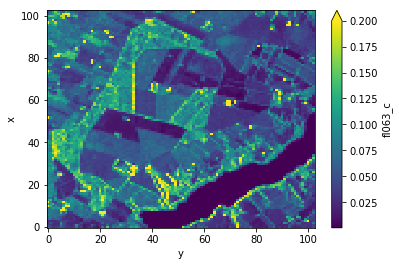

In [11]:
#np.flip(np.abs(ds_ave), axis=0).plot(vmax=0.2)
ds_ave2 = ds_ave.isel(x=slice(None,None,10), y=slice(None,None,10))
np.abs(ds_ave2['fl063_c'].sel(i=0, j=0)).plot(vmax=0.2)

## Q

In [15]:
def rho(p, n, m):
    return 1 - ((2*p**2 - 1)/(6*p)) * (1/n + 1/m - 1/(n + m))

def omega(p, n, m):
    return (-p**2 / 4) * (1 - 1/rho(p, n, m))**2 +\
    ((p**2 * (p**2 -1))/24) *\
    (1/n**2 + 1/m**2 - 1/(n + m)**2) * (1/rho(p, n, m)**2) 

def X(Sx):
    Sx = Sx.copy()
    set0 = np.ones(Sx.shape)
    set0[0,2] = set0[1,2] = set0[1,2] = set0[2,0] = set0[2,1] = 0
    return Sx*set0

def Q(Sx, Sy, n, m):
    X, Y = det(Sx.T), det(Sy.T)
    left = (n + m)**(n + m) / (n**n * m**m)
    right = (X**n * Y**m) / (X + Y)**(m + n)
    return np.real(xr.DataArray(left * right, dims=('x', 'y')))

def probQ(q, p, n, m):
    return -2*rho(p, n, m) * np.log(q)

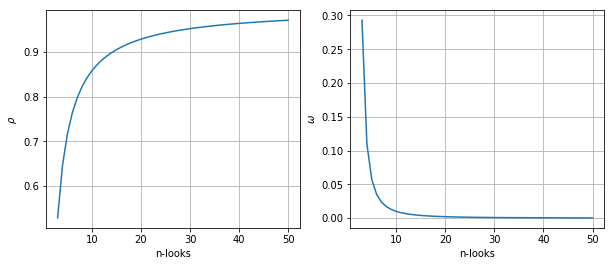

In [16]:
fig, (ax0, ax1) = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))
nlooks = np.arange(3, 51)
ax0.plot(nlooks, rho(3, nlooks, nlooks))
ax0.set_xlabel("n-looks")
ax0.set_ylabel(r"$\rho$")
ax0.grid()
ax1.plot(nlooks, omega(3, nlooks, nlooks))
ax1.set_xlabel("n-looks")
ax1.set_ylabel("$\omega$")
ax1.grid()

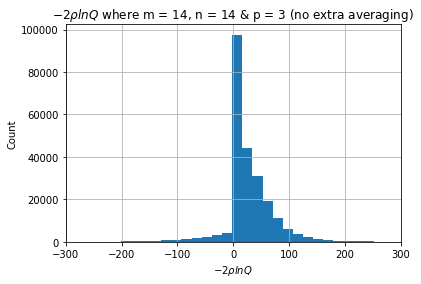

In [46]:
q = Q(ds['fl063_c'], ds['fl064_c'], 14, 14).where(mask>0).where(mask<100)
m = n = 14
p = 3
probQ(q, p, 14, 14).plot.hist(bins=60)
plt.title(rf"$-2 \rho ln Q$ where m = {m}, n = {n} & p = {p} (no extra averaging)");
plt.xlabel(rf'$-2 \rho ln Q$');
plt.ylabel('Count');
plt.xlim(-300, 300)
plt.grid();

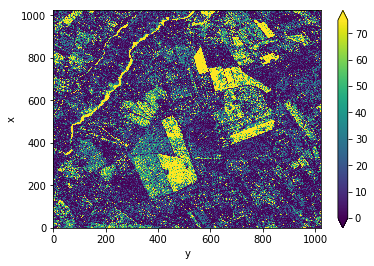

In [47]:
q = Q(ds['fl063_c'], ds['fl064_c'], 14, 14)
probQ(q, p, 14, 14).plot(vmin=0, vmax=75)

## Toolbox for SAR

https://www.orfeo-toolbox.org/CookBook/index_TOC.html

In [16]:
!pwd

/home/jol/Documents/code/dtucourse/polsar_proj
